# Find the original (unshifted) wavelength of all detections

In [14]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pylab as plt
import os

c = 299792 # km/s

In [9]:
# Anna's folder containing all the velocity values.

velshifts = pd.read_csv('/mnt_home/zoek/code/APF-BL-DAP/Zoe/RestWavelengths/velshifts.csv')

In [10]:
# spectra_folder = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/LaserDetectionResults'
# residuals_folder = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/ResidualsResults'
folder = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/AnnaInjectionResults'

In [11]:
sum(velshifts['Velocity_shift [km/s]'] == 0)

3

## Look at the wavelengths of detections in spectra

In [13]:
r_all_detections_df = pd.DataFrame()
s_all_detections_df = pd.DataFrame()

missing_rv_stars = []

for subfolder in glob.glob(folder + '/*'):   
    if not '.csv' in subfolder:
        for csv_file in glob.glob(subfolder + '/*.csv'):
            if not 'detected' in csv_file:

                shifted_wls_this_star = []
                unshifted_wls_this_star = []

                _, data_type, index, star = csv_file.split('_')
                data_type = data_type[-1]
                star = star.split('.')[0]
                if sum(velshifts['Star_name'] == star) == 0:
                    RV = 0
                    missing_rv_stars += [star]
                else:
                    RV = float(velshifts[velshifts['Star_name'] == star]['Velocity_shift [km/s]'])
                table = pd.read_csv(csv_file)

                wls = table['wavelengths'][2].replace('[', '').replace(']', '').split(', ')
                unshifted_wls = []
                for wl in wls:
                    shifted = float(wl)
                    shifted_wls_this_star += [shifted]
                    const = c / (c - RV) # minus sign because we are getting rid of the vel shift
                    unshifted = const * shifted
                    unshifted_wls += [unshifted]
                    unshifted_wls_this_star += [unshifted]

                length = len(shifted_wls_this_star)
                index_col = [int(index)] * length
                star_col = [star] * length

                heights = table['heights'][2].replace('[', '').replace(']', '').split(', ')

                df = pd.DataFrame()
                df[data_type + ' index'] = index_col
                df['star'] = star_col
                df[data_type + ' shifted wl'] = shifted_wls_this_star
                df[data_type + ' unshifted wl'] = unshifted_wls_this_star
                df[data_type + ' heights'] = heights


                if data_type == 'r':
                    r_all_detections_df = pd.concat([r_all_detections_df, df])
                else:
                    s_all_detections_df = pd.concat([s_all_detections_df, df])

                fname = csv_file.replace('.csv', '_detected_wls.csv')
                df.to_csv(fname)

                table['unshifted wavelengths'] = [[], [], unshifted_wls]
                table.to_csv(csv_file)
    
r_all_detections_df.to_csv(folder + '/r_detectionWLs.csv')
s_all_detections_df.to_csv(folder + '/s_detectionWLs.csv')


print('There are a total of ' + str(len(r_all_detections_df)) + ' detections in the residuals.')
print('There are a total of ' + str(len(s_all_detections_df)) + ' detections in the spectra.')

There are a total of 7918 detections in the residuals.
There are a total of 5285 detections in the spectra.


In [6]:
resid_results = pd.read_csv(folder + '/r_detectionWLs.csv')
spect_results = pd.read_csv(folder + '/s_detectionWLs.csv')

resid_results = resid_results[['star', 'r shifted wl', 'r unshifted wl', 'r heights']]

spect_results = spect_results[['star', 's shifted wl', 's unshifted wl', 's heights']]

final_results = pd.merge(
    left = spect_results,
    right = resid_results,
    how="outer",
    left_on=["star", "s shifted wl"], right_on=["star","r shifted wl"])

final_results = final_results.sort_values('star')
final_results.to_csv(folder + '/final_results.csv')

In [7]:
final_results.dropna(subset=['s heights'])

,star,s shifted wl,s unshifted wl,s heights,r shifted wl,r unshifted wl,r heights
291,GJ1002,5721.335767,5722.517343,29.802010,NaN,NaN,NaN
265,GJ1002,5586.257419,5587.411098,4.359434,NaN,NaN,NaN
264,GJ1002,5585.480156,5586.633675,6.961032,NaN,NaN,NaN
263,GJ1002,5583.092170,5584.245195,8.817969,NaN,NaN,NaN
262,GJ1002,5583.016377,5584.169387,7.791545,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4654,TIC286132427,6016.400072,6016.400072,0.193594,NaN,NaN,NaN
4655,TIC286132427,6039.005209,6039.005209,0.289346,NaN,NaN,NaN
4656,TIC286132427,6099.439458,6099.439458,0.474431,NaN,NaN,NaN
4648,TIC286132427,5627.760323,5627.760323,0.380680,NaN,NaN,NaN


In [121]:
# old script for separate residuals and spectra folder
# to use: set folder equal to either the residuals results folder or the spectra results folder


# all_detections_df = pd.DataFrame()

# for subfolder in glob.glob(folder + '/*_*'):
    
#     shifted_wls_this_star = []
#     unshifted_wls_this_star = []
    
#     csv_file = glob.glob(subfolder + '/*.csv')[0]
#     star, index = csv_file.split('_')[-2].split('/')
#     RV = velshifts.loc[int(index)][2]
#     table = pd.read_csv(csv_file)
    
#     wls = table['wavelengths'][2].replace('[', '').replace(']', '').split(', ')
#     unshifted_wls = []
#     for wl in wls:
#         shifted = float(wl)
#         shifted_wls_this_star += [shifted]
#         const = c / (c - RV) # minus sign because we are getting rid of the vel shift
#         unshifted = const * shifted
#         unshifted_wls += [unshifted]
#         unshifted_wls_this_star += [unshifted]
    
#     length = len(shifted_wls_this_star)
#     index_col = [int(index)] * length
#     star_col = [star] * length
        
#     df = pd.DataFrame()
#     df['index'] = index_col
#     df['star'] = star_col
#     df['shifted wl'] = shifted_wls_this_star
#     df['unshifted wl'] = unshifted_wls_this_star
    
#     all_detections_df = pd.concat([all_detections_df, df])

    
#     fname = csv_file.replace('.csv', '_detected_wls.csv')
#     df.to_csv(fname)
    
#     table['unshifted wavelengths'] = [[], [], unshifted_wls]
#     table.to_csv(csv_file)
    
# all_detections_df.to_csv(folder + '/detectionWLs.csv')

# print('There are a total of ' + str(len(all_detections_df)) + ' detections.')

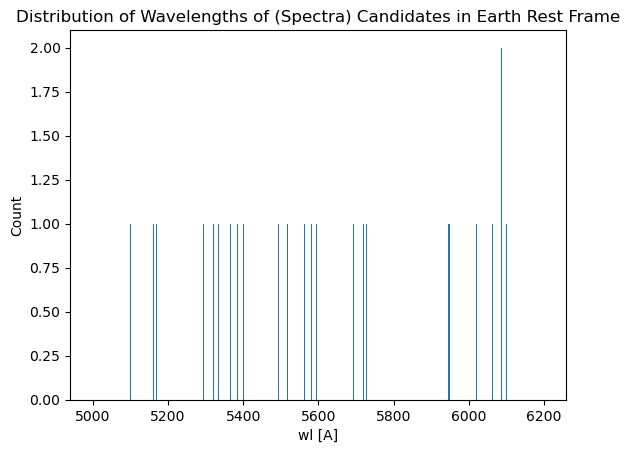

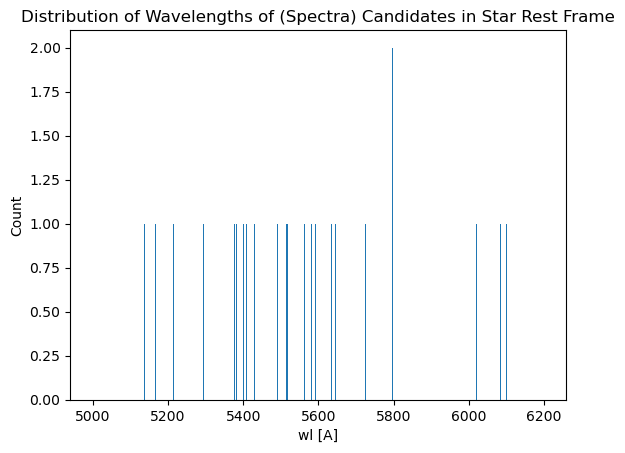

In [43]:
hist_step = 1

plt.hist(s_all_detections_df['unshifted wl'], bins = np.arange(5000, 6200, step=hist_step))
plt.title('Distribution of Wavelengths of (Spectra) Candidates in Earth Rest Frame')
plt.xlabel('wl [A]')
plt.ylabel('Count')
# plt.xlim(5000, 5200)
plt.show()

plt.hist(s_all_detections_df['shifted wl'], bins = np.arange(5000, 6200, step=hist_step))
plt.title('Distribution of Wavelengths of (Spectra) Candidates in Star Rest Frame')
plt.xlabel('wl [A]')
plt.ylabel('Count')
# plt.xlim(5000, 5200)
plt.show()

## Look at the wavelengths of detections in residuals

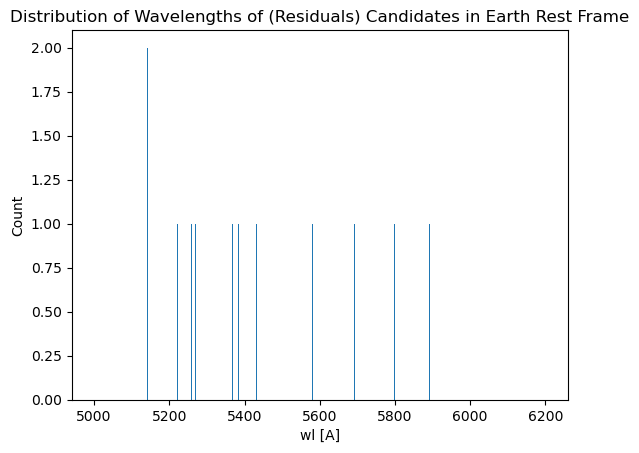

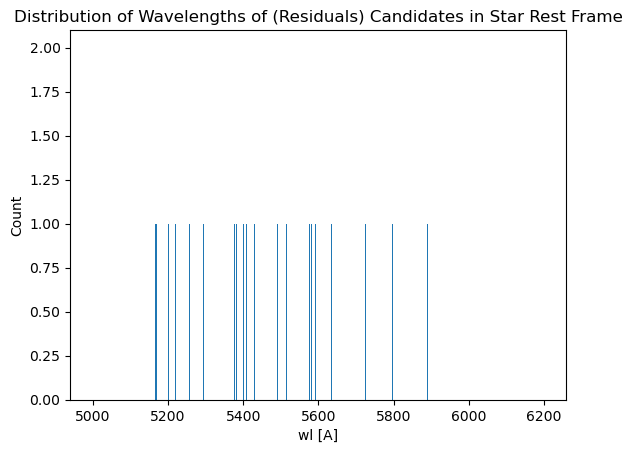

In [44]:
hist_step = 1

plt.hist(r_all_detections_df['unshifted wl'], bins = np.arange(5000, 6200, step=hist_step))
plt.title('Distribution of Wavelengths of (Residuals) Candidates in Earth Rest Frame')
plt.xlabel('wl [A]')
plt.ylabel('Count')
# plt.xlim(5000, 5200)
plt.show()

plt.hist(r_all_detections_df['shifted wl'], bins = np.arange(5000, 6200, step=hist_step))
plt.title('Distribution of Wavelengths of (Residuals) Candidates in Star Rest Frame')
plt.xlabel('wl [A]')
plt.ylabel('Count')
# plt.xlim(5000, 5200)
plt.show()

## Look at most common wavelengths of detection

In [45]:
# plt.hist(list(all_detections_df['unshifted wl']), bins = np.arange(5000, 6200, step=hist_step))
# plt.title('Distribution of Wavelengths of (Residuals) Candidates in Earth Rest Frame')
# plt.xlabel('wl [A]')
# plt.ylabel('Count')
# # plt.xlim(5016, 5019)
# plt.show()

In [46]:
# all_detections_df[all_detections_df['unshifted wl'].between(5016, 5018)].sort_values('index')